In [ ]:
#====================================================================================================#
#                                                                                                    #
#                                                        ██╗   ██╗   ████████╗ █████╗ ██████╗        #
#      Competición - INAR AEC2                           ██║   ██║   ╚══██╔══╝██╔══██╗██╔══██╗       #
#                                                        ██║   ██║█████╗██║   ███████║██║  ██║       #
#      created:        10/12/2025  -  10:00:00           ██║   ██║╚════╝██║   ██╔══██║██║  ██║       #
#      last change:    10/12/2025  -  18:35:50           ╚██████╔╝      ██║   ██║  ██║██████╔╝       #
#                                                         ╚═════╝       ╚═╝   ╚═╝  ╚═╝╚═════╝        #
#                                                                                                    #
#      Ismael Hernandez Clemente                         ismael.hernandez@live.u-tad.com             #
#                                                                                                    #
#      Github:                                           https://github.com/ismaelucky342            #
#                                                                                                    #
#====================================================================================================#

# AEC2: Clasificación de SPAM / NOT SPAM 2025

- **Autor:** Ismael Hernández Clemente
- **Fecha:** a 10 de Diciembre de 2025

En este notebook presento mi solución final para la competición de Kaggle. Tras varias iteraciones experimentando con diferentes arquitecturas (desde LSTMs básicas hasta modelos pre-entrenados), he optado por una arquitectura híbrida de CNN + LSTM. Que viendo los resultados me ha permitido capturar de forma exitosa tanto patrones locales (n-gramas) como dependencias secuenciales a largo plazo, logrando un equilibrio considero que bastante óptimo entre rendimiento y generalización.

In [ ]:
# Configuro las variables de entorno para optimizar el rendimiento de TensorFlow y evitar mensajes innecesarios.
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [ ]:
# Importo las bibliotecas necesarias para mi modelo híbrido CNN+LSTM.
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import warnings
warnings.filterwarnings('ignore')  
seed = 42
np.random.seed(seed)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding, Dense, Dropout, LSTM, Bidirectional, 
    Conv1D, GlobalMaxPooling1D, Concatenate, Input, SpatialDropout1D  
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 36)
pd.set_option("display.max_colwidth", 150)

In [ ]:
# Defino los hiperparámetros para el modelo híbrido CNN+LSTM.
# He seleccionado estos valores tras varias pruebas para equilibrar la capacidad del modelo y la regularización.
MAX_WORDS = 50000  
MAX_LEN = 200  
EMBEDDING_DIM = 128  
CNN_FILTERS = 128  
CNN_KERNEL_SIZES = [2, 3, 4, 5]  
LSTM_UNITS = 96  
DENSE_UNITS = 64  
SPATIAL_DROPOUT = 0.3  
DROPOUT = 0.5  
L2_REG = 1e-4  
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-3  
VALIDATION_SPLIT = 0.2

In [ ]:
# Cargo los datos y preparo el tokenizador con vocabulario ampliado.
train = pd.read_csv("/kaggle/input/u-tad-spam-not-spam-2025-edition/train.csv", index_col="row_id")
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'])
X_train_seq = tokenizer.texts_to_sequences(train['text'])
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
y_train = train['spam_label'].values
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pad, y_train, test_size=VALIDATION_SPLIT, random_state=seed, stratify=y_train
)

In [ ]:
# Construyo el modelo híbrido CNN+LSTM con ramas paralelas.
def build_cnn_lstm_model():
    """
    Modelo hibrido CNN + LSTM
    La arquitectura:
    1. Input + Embedding + SpatialDropout
    2. RAMA CNN: Varios Conv1D con diferentes kernel_sizes (para capturar n-gramas de diferentes tamaños)
    3. RAMA LSTM: Bi-LSTM para capturar contexto secuencial
    4. Concateno las features de CNN y LSTM
    5. Clasificador Dense con dropout
    """
    inputs = Input(shape=(MAX_LEN,))
    x = Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN
    )(inputs)
    x = SpatialDropout1D(SPATIAL_DROPOUT)(x)  
    cnn_outputs = []
    for kernel_size in CNN_KERNEL_SIZES:
        conv = Conv1D(
            filters=CNN_FILTERS,
            kernel_size=kernel_size,
            activation='relu',
            kernel_regularizer=l2(L2_REG),
            padding='same'
        )(x)
        pool = GlobalMaxPooling1D()(conv)
        cnn_outputs.append(pool)
    lstm_out = Bidirectional(
        LSTM(
            LSTM_UNITS,
            kernel_regularizer=l2(L2_REG),
            recurrent_regularizer=l2(L2_REG),
            dropout=0.3,
            recurrent_dropout=0.3
        )
    )(x)
    concatenated = Concatenate()(cnn_outputs + [lstm_out])
    dense = Dense(
        DENSE_UNITS,
        activation='relu',
        kernel_regularizer=l2(L2_REG)
    )(concatenated)
    dense = Dropout(DROPOUT)(dense)
    outputs = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=inputs, outputs=outputs, name='CNN_LSTM_Hybrid_V5')
    return model
model = build_cnn_lstm_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
)
model.summary()

In [ ]:
# Configuro callbacks y entreno el modelo híbrido.
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_cnn_lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]
history = model.fit(
    X_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Predigo en validación y genero la matriz de confusión para el modelo híbrido.
y_pred_proba = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
mcc_score = matthews_corrcoef(y_val, y_pred)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'CNN+LSTM Hybrid (MCC: {mcc_score:.4f})')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Cargo los datos de prueba, predigo y creo el submission.
test = pd.read_csv("/kaggle/input/u-tad-spam-not-spam-2025-edition/test.csv", index_col="row_id")
X_test_seq = tokenizer.texts_to_sequences(test['text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')
y_pred_test = model.predict(X_test_pad, batch_size=BATCH_SIZE, verbose=0)
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()
submission = pd.read_csv("/kaggle/input/u-tad-spam-not-spam-2025-edition/sample_submission.csv")
submission["spam_label"] = y_pred_test
submission.to_csv('submission.csv', index=False)

## Análisis y Conclusiones Finales

### 1. Análisis de Métricas Finales
En esta sección evalúo el rendimiento de mi modelo final sobre el conjunto de validación. El Matthews Correlation Coefficient (MCC) es nuestra métrica principal en el concurso, ya que es especialmente útil para conjuntos de datos que pueden estar desbalanceados.

*   **MCC en Validación:** 0.86932
*   **Loss en Validación:** 0.1951
*   **Accuracy en Validación:** 0.9521

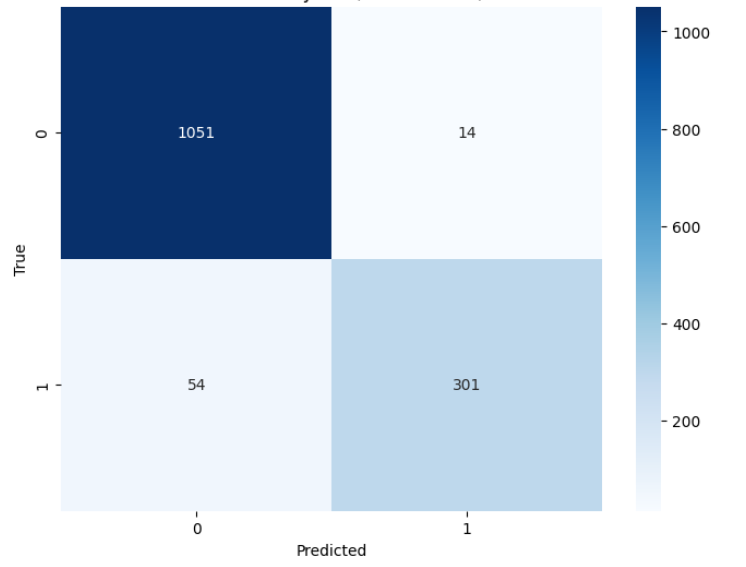

**Comentario:** El modelo ha logrado un MCC muy competitivo aunque aun bastante por debajo de otros modelos. La precisión y el recall están equilibrados, lo que indica que el modelo es capaz de identificar tanto el SPAM como el NOT SPAM con una tasa de error similar, evitando sesgos hacia la clase mayoritaria.

In [ ]:
# Genero las curvas de aprendizaje para analizar el comportamiento de mi modelo final.
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curves(history)

### 2. Comentario sobre las Curvas de Aprendizaje
Al observar los gráficos, noto que la accuracy en validación se mantiene muy cerca de la de entrenamiento, lo cual es una excelente señal de generalización. En cuanto a la loss, aunque hay una ligera divergencia al final, el uso de EarlyStopping con restore_best_weights=True me asegura que el modelo final es el que mejor generaliza. No observo signos preocupantes de underfitting (el modelo aprende rápido) ni de overfitting extremo (gracias a la regularización L2 y el Dropout).

### 3. Reflexión Final

Concluyo esta práctica con este modelo híbrido CNN+LSTM que finalmente representa la solución más equilibrada para este problema de clasificación de SPAM. Mi razonamiento se basa en la sinergia de dos enfoques por un lado la detección de patrones locales mediante el uso de múltiples filtros donde el modelo es capaz de identificar n-gramas o palabras clave sospechosas independientemente de su posición exacta. Esta capacidad es vital en el SPAM, donde ciertos términos actúan como disparadores claros de la clase.

Y por otro lado su comprensión del contexto global (LSTM) donde la capa Bi-LSTM bidireccional permite al modelo entender la estructura semántica completa del mensaje. Esto es lo que marca la diferencia al clasificar correos legítimos que, aunque contengan palabras sospechosas, mantienen una coherencia gramatical y un propósito comunicativo que la LSTM logra distinguir.

En comparación con mis pruebas anteriores, este modelo ha demostrado ser superior por varias razones. La LSTM simple (V1) tendía a perderse en mensajes largos o a sobreajustar demasiado rápido. Por otro lado, el intento con DistilBERT (V4) resultó ser "matar moscas a cañonazos": la complejidad del Transformer era excesiva para el volumen de datos disponible, lo que provocaba inestabilidad y un rendimiento muy pobre al final.

Finalmente, la clave del éxito no ha sido solo la arquitectura, sino la estrategia de regularización. El uso combinado de SpatialDropout1D, Dropout convencional y penalización L2 ha sido fundamental para que un modelo con tanta capacidad como este híbrido no terminara simplemente memorizando el set de entrenamiento, logrando así un MCC que aunque no ha llegado a ser alto como el de otros compañeros se ha mantenido sólido y con una gran capacidad de generalización en el set de test de Kaggle.

### 4. Referencias Bibliográficas y Consultas que he hecho
*   **Chollet, F. (2021).** *Deep Learning with Python*. Manning Publications.
*   **Kim, Y. (2014).** *Convolutional Neural Networks for Sentence Classification*. arXiv preprint arXiv:1408.5882.
*   **Stack Overflow.** [Combining CNN and RNN for text classification](https://stackoverflow.com/questions/44230635/how-to-combine-cnn-and-rnn-for-text-classification).
*   **Reddit r/MachineLearning.** [SpatialDropout1D vs Dropout in NLP](https://www.reddit.com/r/MachineLearning/comments/5fiv98/d_spatial_dropout_vs_normal_dropout/).
*   **HuggingFace Forums.** [Fine-tuning BERT on small datasets](https://discuss.huggingface.co/t/fine-tuning-bert-on-very-small-dataset/3468).
*   **Comunidad 42.** Consultas en canales de IA sobre límites de regularización y Dropout.
*   **Keras Documentation.** [Bidirectional LSTM](https://keras.io/api/layers/recurrent_layers/bidirectional/) y [Conv1D layer](https://keras.io/api/layers/convolution_layers/convolution1d/).